In [280]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt


from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer


from sklearn.model_selection import train_test_split

import os
from wordcloud import WordCloud
from PIL import Image

from sklearn.utils import resample


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


#https://github.com/briannalytle/reddit_nlp/blob/master/EDA.ipynb


[nltk_data] Downloading package stopwords to C:\Users\Alberto
[nltk_data]     Vilas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Alberto
[nltk_data]     Vilas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [281]:
df = pd.read_csv("reddit_hot_submissions.csv")
print(df.head(2))

                                               title          time  \
0  AOC Says U.S. 'Must Atone' for Rights Violatio...  1600174531.0   
1  The Mandalorian | Season 2 Official Trailer | ...  1600178449.0   

  description num_comments num_upvotes upvote_ratio link_flair   nsfw  \
0         NaN          655       14641         0.95        NaN  False   
1         NaN         1122        9638         0.97         TV  False   

                                     subreddit_title          redditor  \
0                                           Politics  MatrixCapitalism   
1  Star Wars - A long time ago, in a galaxy far, ...         raynehk14   

                                                 url  
0  https://www.newsweek.com/aoc-us-must-atone-rig...  
1        https://www.youtube.com/watch?v=eW7Twd85m2g  


Convert target to binary

In [282]:
df['nsfw'] = [1 if n=='True' else 0 for n in df.nsfw]

In [283]:
df['nsfw'].value_counts()

0    10802
1      190
Name: nsfw, dtype: int64

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10992 entries, 0 to 10991
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            10992 non-null  object
 1   time             10992 non-null  object
 2   description      389 non-null    object
 3   num_comments     10992 non-null  object
 4   num_upvotes      10992 non-null  object
 5   upvote_ratio     10992 non-null  object
 6   link_flair       4379 non-null   object
 7   nsfw             10992 non-null  int64 
 8   subreddit_title  10992 non-null  object
 9   redditor         10992 non-null  object
 10  url              10992 non-null  object
dtypes: int64(1), object(10)
memory usage: 944.8+ KB


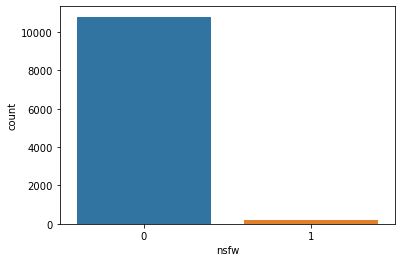

In [285]:
sns.countplot(x='nsfw', data=df)

Replace NaN with ' ', because it's necessary for df.title + df.description

Because tittle + description is a better field 


In [286]:
df['description']=df['description'].replace(np.nan, " ")
df['all_text'] = df['title'] + df['description']
df.head()

,title,time,description,num_comments,num_upvotes,upvote_ratio,link_flair,nsfw,subreddit_title,redditor,url,all_text
0,AOC Says U.S. 'Must Atone' for Rights Violatio...,1600174531.0,,655,14641,0.95,NaN,0,Politics,MatrixCapitalism,https://www.newsweek.com/aoc-us-must-atone-rig...,AOC Says U.S. 'Must Atone' for Rights Violatio...
1,The Mandalorian | Season 2 Official Trailer | ...,1600178449.0,,1122,9638,0.97,TV,0,"Star Wars - A long time ago, in a galaxy far, ...",raynehk14,https://www.youtube.com/watch?v=eW7Twd85m2g,The Mandalorian | Season 2 Official Trailer | ...
2,Russian opposition leader Alexei Navalny share...,1600170269.0,,1427,53426,0.96,NaN,0,Reddit Pics,unknown_human,https://i.redd.it/75deaqxztan51.jpg,Russian opposition leader Alexei Navalny share...
3,The Big True,1600171199.0,,308,27384,0.97,NaN,0,People Person's Paper People,SpongeNoob24,https://v.redd.it/pipkbc6ywan51,The Big True
4,"TIL Ray Burton, who was the father of Cliff Bu...",1600168707.0,,954,39959,0.94,NaN,0,Today I Learned (TIL),phantom416,https://loudwire.com/cliff-burton-father-donat...,"TIL Ray Burton, who was the father of Cliff Bu..."


In [287]:
df.groupby(['nsfw']).describe()

title                                                    time         \
      count unique                                  top freq  count unique   
nsfw                                                                         
0     10802    989       PsBattle: This dog in a market  100  10802    997   
1       190     89  Any lacy lingerie [f]ans out there?   98    190     89   

                        description         ...             redditor       \
               top freq       count unique  ...                  top freq   
nsfw                                        ...                             
0     1600256135.0  100       10802     62  ...       WorldTheAround  200   
1     1600258061.0   98         190      2  ...  _weliveinasexciety_   98   

        url                                                  all_text         \
      count unique                                  top freq    count unique   
nsfw                                                                           
0     10802    991  https://i.redd.it/5hp2bhmylin51.jpg  100    10802    989   
1       190     89      https://i.imgur.com/Im00qJz.jpg   98      190     89   

                                                 
                                       top freq  
nsfw                                             
0     When someone keeps talking bullshit   100  
1     Any lacy lingerie [f]ans out there?    98  

[2 rows x 44 columns]

# Clean Data


In [288]:
#Remove punctuacion and special characters based on pattern using RegEx

#remove punctuation and special characters
tokenizer = RegexpTokenizer(r'\w+')


df['all_text'] = df['all_text'].apply(lambda  x: tokenizer.tokenize(x.lower()))

df["all_text"].head()

0    [aoc, says, u, s, must, atone, for, rights, vi...
1    [the, mandalorian, season, 2, official, traile...
2    [russian, opposition, leader, alexei, navalny,...
3                                     [the, big, true]
4    [til, ray, burton, who, was, the, father, of, ...
Name: all_text, dtype: object

# Remove Stop Words


In [289]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [290]:
df['all_text'] = df['all_text'].apply(lambda  x: remove_stopwords(x))

# Stemming & Lemmatizing

In [291]:
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem

stemmer = PorterStemmer()

def word_stemmer(text):
    stem = " ".join([stemmer.stem(i) for i in text])
    return stem

In [292]:
df['all_text_l'] = df['all_text'].apply(lambda  x: word_lemmatizer(x))
df['all_text_s'] = df['all_text'].apply(lambda  x: word_stemmer(x))

print(df['all_text_s'])

0        aoc say u must aton right violat whistleblow i...
1               mandalorian season 2 offici trailer disney
2        russian opposit leader alexei navalni share fi...
3                                                 big true
4        til ray burton father cliff burton use cliff r...
                               ...                        
10987                        witchcraft definit patriarchi
10988                                    save endang speci
10989                           nippolass master tit slice
10990                                      pure shock face
10991                                    guid fountain pen
Name: all_text_s, Length: 10992, dtype: object


# Word Cloud Visualization

In [293]:
df_sfw = df[df.nsfw==0]
df_nsfw = df[df.nsfw==1]

def create_word_cloud(df):
    """
        Word cloud requires input of string
    """
    df_list = df['all_text_l'].tolist()
    df_string = ("").join(df_list)
    
    wordcloud = WordCloud(max_font_size = 50, max_words=50, margin=0, background_color = "white", colormap="Reds").generate(df_string)

    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    


Word Cloud - nsfw

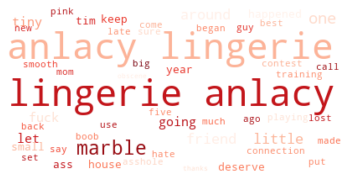

In [294]:
create_word_cloud(df_nsfw)

Word Cloud - sfw

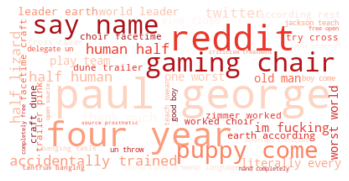

In [295]:
create_word_cloud(df_sfw)

# Handle imbalanced datasets

In [296]:
df["nsfw"].value_counts()

0    10802
1      190
Name: nsfw, dtype: int64

In [297]:
# Down-sample Majority Class

df_sfw_downsampled = resample(df_sfw, 
                                 replace=False,    # sample without replacement
                                 n_samples=190,     # to match minority class
                                 random_state=0)

df_downsampled = pd.concat([df_sfw_downsampled, df_nsfw])
df_downsampled.nsfw.value_counts()

1    190
0    190
Name: nsfw, dtype: int64

# Split train and test data

In [298]:
#define target var
y=df_downsampled['nsfw']

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['all_text_l'], y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(304,) (304,)
(76,) (76,)


# Tf-IDF Vectorizer

In [299]:
#Naives bayes requires Tf-IDF vectors

x_lst = X_train.tolist()
y_lst = y_test.tolist()
vectorizer = TfidfVectorizer()
vetor_train_transformed = vectorizer.fit_transform(x_lst) #gives tf idf vector for x_train
vetor_test_transformed  = vectorizer.transform(X_test) #gives tf idf vector for x_test

# Fit/Train Model

## Naives Bayes

In [300]:
model = MultinomialNB()
model.fit(vetor_train_transformed, y_train)

MultinomialNB()

In [301]:
pred = model.predict(vetor_test_transformed)

In [306]:
def validation(y_lst,pred):
    matrix = confusion_matrix(y_lst, pred)
    print('Confusion Matrix :')
    sns.heatmap(matrix, annot=True)
    print ('Accuracy Score :',accuracy_score(y_lst, pred))
    print ('Report : ')
    print (classification_report(y_lst, pred) )
    score_2 = f1_score(y_lst, pred, average = 'binary')
    print('F-Measure: %.3f' % score_2)

Confusion Matrix :
Accuracy Score : 0.8289473684210527
Report : 
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        34
           1       0.94      0.74      0.83        42

    accuracy                           0.83        76
   macro avg       0.84      0.84      0.83        76
weighted avg       0.85      0.83      0.83        76

F-Measure: 0.827


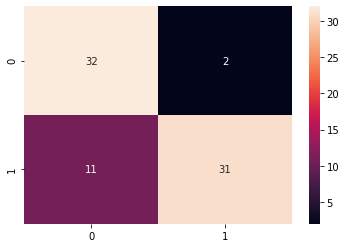

In [307]:
validation(y_lst,pred)